In [9]:
%pylab inline

import numpy as np
import tensorflow as tf
import subprocess
from tqdm import tqdm

import sys
sys.path.append('../core')
sys.path.append('../../Xi_to_q/core')

from Xi_gen import Xi_gen
from LSTM_ROM import LSTM_ROM
from Xi_to_q_net import Xi_to_q_net

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # comment to use GPU

Populating the interactive namespace from numpy and matplotlib


In [10]:
# Load model for Xi to q without forecast
Q = Xi_to_q_net(restart_file='../../Xi_to_q/saved_models/Xi_q_NN_tau0.0.npy')

# Load LSTM dynamic model for Xi
H = LSTM_ROM(restart_file='../saved_models/Xi_ROM_32.npy')

# Load Psi from file to get normalization used by LSTM model
Xi = np.load('../../P_to_Xi/dense_Xi_predictions/Xi_32.npy', allow_pickle=True).item()['Xi']
Xi_mean = np.mean(Xi, axis=0)
Xi_std = np.std(Xi, axis=0)

# Set up data generator
r = 32
n_steps = 350
batch_size = 1000
m_hist = 70
stride = 3

t = 0.01*stride*np.arange(n_steps+1)
gen = Xi_gen(r, n_steps, batch_size, m_hist, stride, return_q=True)

In [11]:
if False:

    Error = []
    Q_Error = []
    n_batches = gen.test_batches

    for batch in tqdm(range(n_batches)):

        Xi_hist, Xi_forecast, Q_true, batch_inds = gen.next_test(return_inds=True)
        Q_error_init = gen.q[batch_inds].reshape(len(batch_inds),1) - Q.network(Xi_hist[:,-1,:]*Xi_std + Xi_mean).numpy()
        Xi_est = []

        for step in range(n_steps):
            Xi_est.append(tf.expand_dims(H.network(Xi_hist), axis=1))
            Xi_hist = tf.concat([Xi_hist[:,1:,:], Xi_est[-1]], axis=1)

        Xi_est = tf.concat(Xi_est,axis=1).numpy()
        Q_est = np.hstack([Q.network(Xi_est[:,j,:]*Xi_std + Xi_mean).numpy() for j in range(n_steps)])

        Error.append(np.hstack([np.zeros((len(batch_inds),1,32)), Xi_forecast - Xi_est]))
        Q_Error.append(np.hstack([Q_error_init, Q_true - Q_est]))

    error = np.vstack(Error)
    q_error = np.vstack(Q_Error)
    
    error_dict = {'Xi_error' : error, 'q_error' : q_error}
    np.save('Xi_ROM_32_error', error_dict)
    
else:
    error_dict = np.load('Xi_ROM_32_error.npy',allow_pickle=True).item()
    error = error_dict['Xi_error']
    q_error = error_dict['q_error']

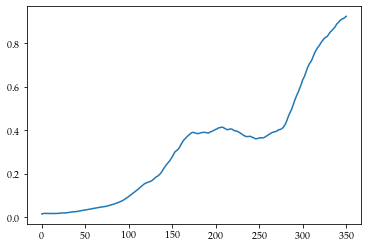

In [12]:
plot(np.mean(np.abs(q_error**2),axis=0))

In [13]:
mse_ind = np.linalg.norm(error,axis=2)**2 / error.shape[2]
mse_batch = np.linalg.norm(error,axis=0)**2 / error.shape[0]

(0.0, 10.5)

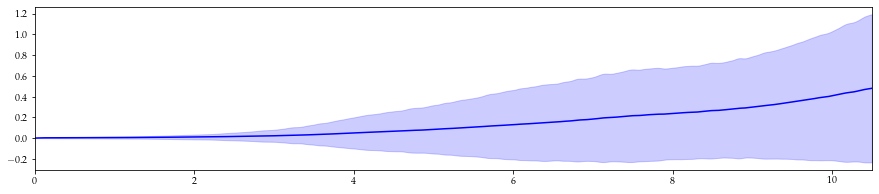

In [14]:
figure(figsize = (15,3))
plot(t,np.mean(mse_ind,axis=0), color='b')
fill_between(t,np.mean(mse_ind,axis=0)-np.std(mse_ind,axis=0),
     np.mean(mse_ind,axis=0)+np.std(mse_ind,axis=0), color='b', alpha=0.2)
xlim([t[0],t[-1]])

<ipython-input-15-96ec37acb255>:6: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm=matplotlib.colors.SymLogNorm(linthresh=0.01, linscale=1,
<ipython-input-15-96ec37acb255>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(t,(x[1:]+x[:-1])/2, error_hist, shading='auto', cmap='Blues',


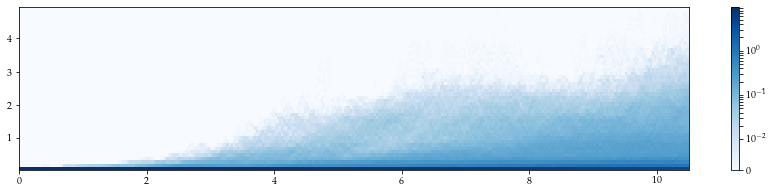

In [15]:
figure(figsize = (15,3))

x = np.linspace(0,5,50)
error_hist = np.stack([np.histogram(mse_ind[:,i],bins=x,density=True)[0] for i in range(n_steps)],axis=1)
pcolor(t,(x[1:]+x[:-1])/2, error_hist, shading='auto', cmap='Blues', 
       norm=matplotlib.colors.SymLogNorm(linthresh=0.01, linscale=1,
                                         vmin=0, vmax=np.max(error_hist)))
colorbar()

<ipython-input-16-d35050effc16>:5: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm=matplotlib.colors.SymLogNorm(linthresh=0.01, linscale=1,
<ipython-input-16-d35050effc16>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(t,(x[1:]+x[:-1])/2, error_hist, shading='auto',cmap='Blues',


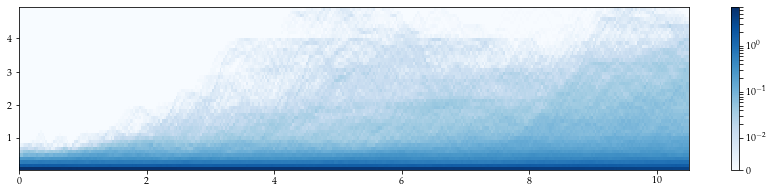

In [16]:
x = np.linspace(0,5,50)
error_hist = np.stack([np.histogram(np.abs(q_error[:,i]),bins=x,density=True)[0] for i in range(n_steps)],axis=1)
figure(figsize = (15,3))
pcolor(t,(x[1:]+x[:-1])/2, error_hist, shading='auto',cmap='Blues', 
       norm=matplotlib.colors.SymLogNorm(linthresh=0.01, linscale=1,
                                         vmin=0, vmax=np.max(error_hist)))
colorbar()